In [1]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import pickle
import pygmo as pg

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib_scalebar.scalebar import ScaleBar

%matplotlib inline

from spineq.optimise import (
    calc_oa_weights,
    calc_coverage,
    optimise,
    get_optimisation_inputs,
)
from spineq.genetic import build_problem, run_problem
from spineq.plotting import (
    plot_oa_importance,
    plot_oa_weights,
    plot_optimisation_result,
    plot_sensors,
    plot_coverage_grid,
    get_fig_grid,
    add_colorbar,
    add_scalebar,
    save_fig,
)
from spineq.data_fetcher import get_uo_sensors
from spineq.urb_obs import get_uo_sensor_dict, plot_uo_coverage_grid
from spineq.utils import coverage_grid

In [2]:
regen_results = False

In [3]:
# fivethirtyeight style defaults but with white background
plt.style.use("fivethirtyeight")
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["savefig.facecolor"] = "white"

save_dir = "paper_figures"
os.makedirs(save_dir, exist_ok=True)

In [4]:
population_groups = {
    "pop_total": {"min": 0, "max": 90, "weight": 1, "title": "Total Population"},
    "pop_children": {"min": 0, "max": 16, "weight": 1, "title": "Children"},
    "pop_elderly": {"min": 70, "max": 90, "weight": 1, "title": "Elderly"},
}

all_groups = dict(population_groups)
all_groups["workplace"] = {"title": "Workplace"}

## Distribution of Demographic Variables

In [5]:
oa_weights = {}

for name, weights in population_groups.items():
    oa_weights[name] = calc_oa_weights(
        pop_age_groups={name: weights}, population_weight=1, workplace_weight=0
    )

oa_weights["workplace"] = calc_oa_weights(population_weight=0, workplace_weight=1)

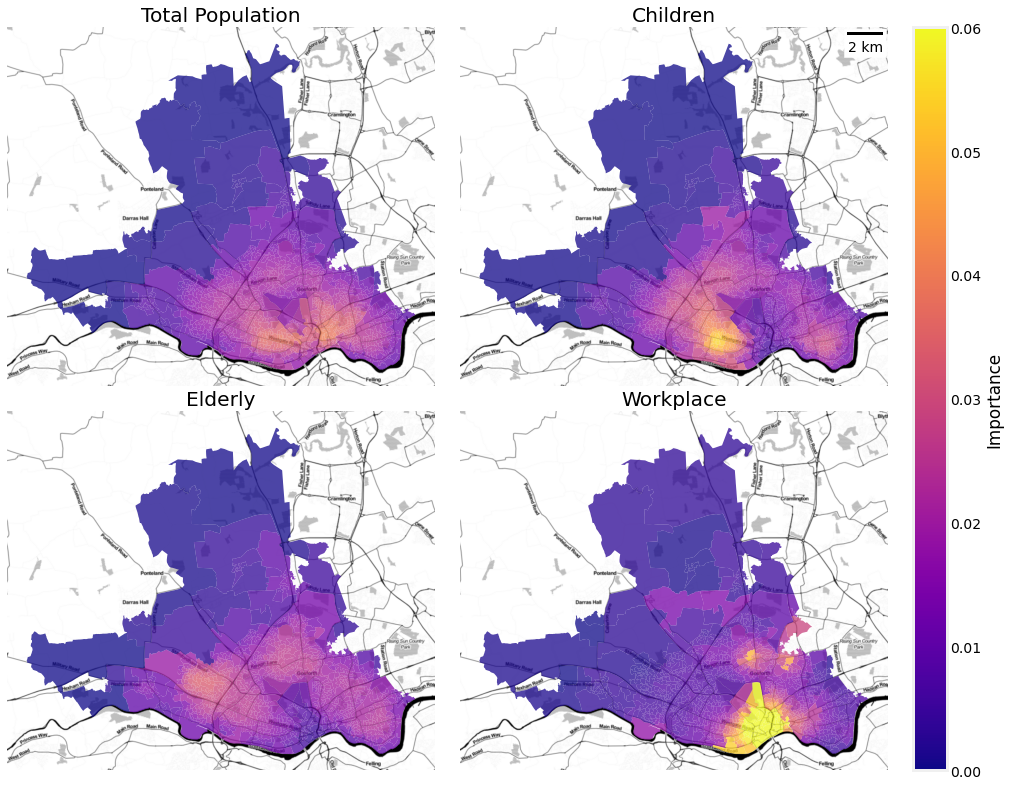

In [6]:
theta = 500
vmax = 0.06

fig, grid = get_fig_grid()

for i, g in enumerate(all_groups.items()):
    name = g[0]
    title = g[1]["title"]
    plot_oa_importance(
        oa_weights[name],
        theta=theta,
        vmax=vmax,
        ax=grid[i],
        show=False,
        legend=False,
        title=title,
    )
    if i == 1:
        add_scalebar(grid[i])

add_colorbar(grid[-1], vmax=vmax, label="Importance")
save_fig(fig, "demographics_importance.png", save_dir)

In [7]:
from spineq.data_fetcher import get_oa_shapes, get_oa_stats

oa = get_oa_shapes()
oa["area"] = oa["geometry"].area / 1e6  # km^2

stats = get_oa_stats()
for name, config in population_groups.items():
    group_pop = (
        stats["population_ages"]
        .loc[
            :,
            (stats["population_ages"].columns >= config["min"])
            & (stats["population_ages"].columns <= config["max"]),
        ]
        .sum(axis=1)
    )
    group_pop.name = name
    oa = oa.join(group_pop)

workplace = stats["workplace"]
workplace.name = "workplace"
oa = oa.join(workplace)

for group in all_groups.keys():
    oa[f"{group}_perc"] = oa[group] / oa[group].sum()
    oa[f"{group}_reld"] = oa[f"{group}_perc"] / oa["area"]

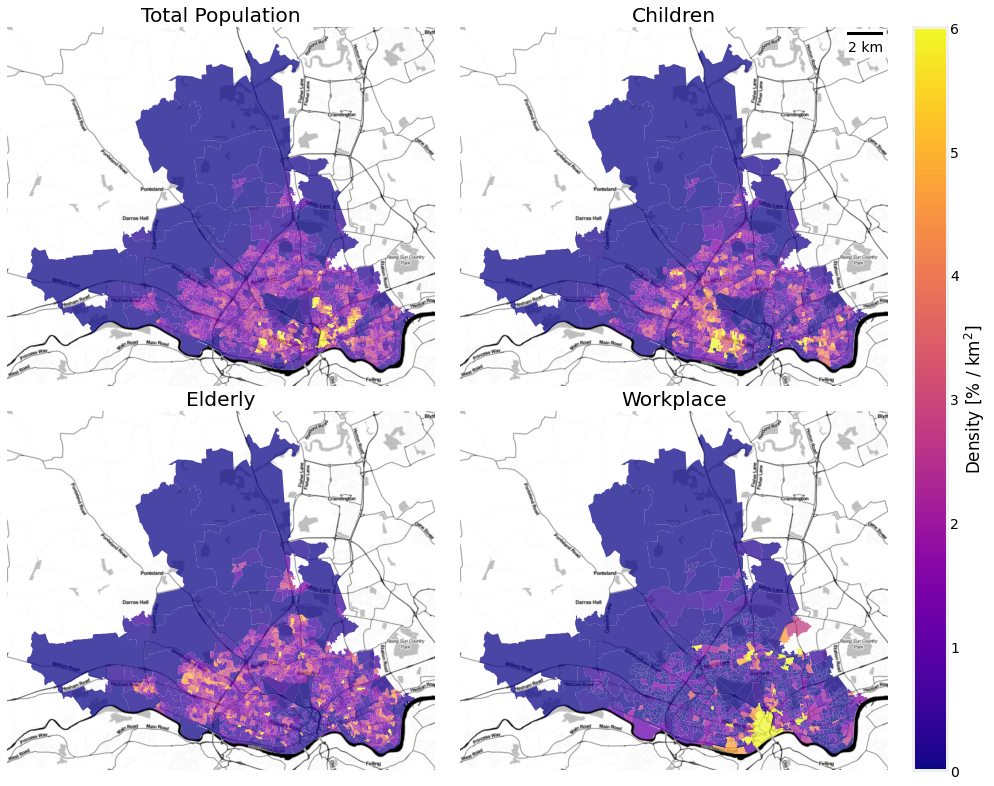

In [8]:
vmax = 6
fig, grid = get_fig_grid()

for i, g in enumerate(all_groups.items()):
    name = g[0]
    title = g[1]["title"]
    plot_oa_weights(
        100 * oa[f"{name}_reld"],
        title=title,
        vmax=vmax,
        ax=grid[i],
        legend=False,
        show=False,
    )
    if i == 1:
        add_scalebar(grid[i])

add_colorbar(grid[-1], vmax=vmax, label="Density [% / $\mathrm{km}^2$]")
save_fig(fig, "demographics_density.png", save_dir)

## Single-Variable Networks


In [9]:
thetas = [100, 250, 500]
n_sensors = [10, 20, 50, 55]

In [10]:
networks_path = Path(save_dir, "networks_singleobj.pkl")

if regen_results:
    results = {}

    for name, weights in population_groups.items():
        results[name] = {}

        for theta in thetas:
            results[name][f"theta{theta}"] = {}

            for n in n_sensors:
                print("=" * 20)
                print(name, ", theta", theta, ", n_sensors", n)
                print("=" * 20)
                result = optimise(
                    n_sensors=n,
                    theta=theta,
                    population_weight=1,
                    workplace_weight=0,
                    pop_age_groups={name: weights},
                )
                results[name][f"theta{theta}"][f"{n}sensors"] = result

    name = "workplace"
    results[name] = {}
    for theta in thetas:
        results[name][f"theta{theta}"] = {}

        for n in n_sensors:
            print("=" * 20)
            print(name, ", theta", theta, ", n_sensors", n)
            print("=" * 20)
            result = optimise(
                n_sensors=n,
                theta=theta,
                population_weight=0,
                workplace_weight=1,
            )
            results[name][f"theta{theta}"][f"{n}sensors"] = result

    with open(networks_path, "wb") as f:
        pickle.dump(results, f)

else:
    with open(networks_path, "rb") as f:
        results = pickle.load(f)

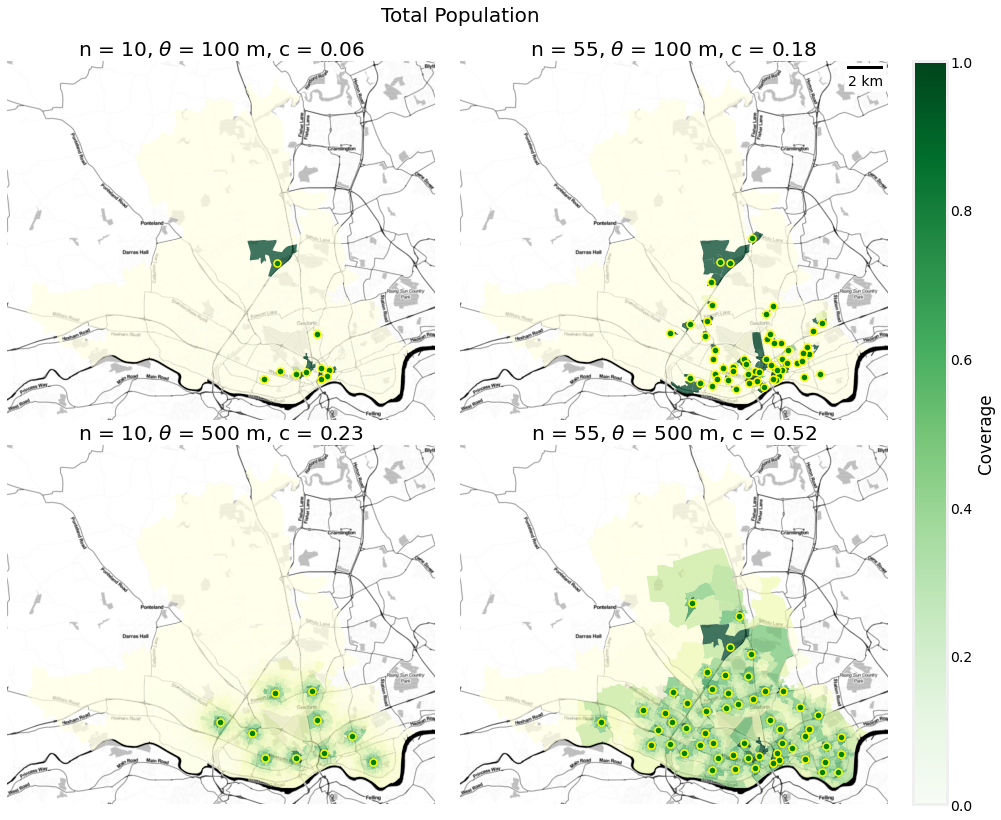

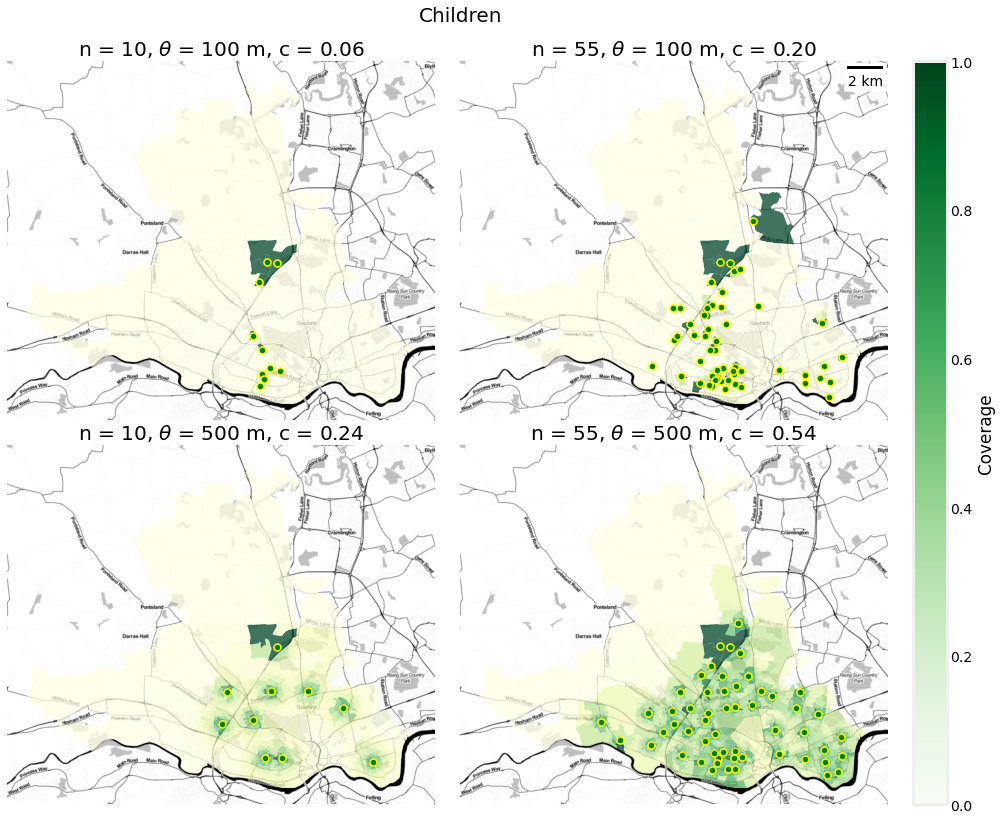

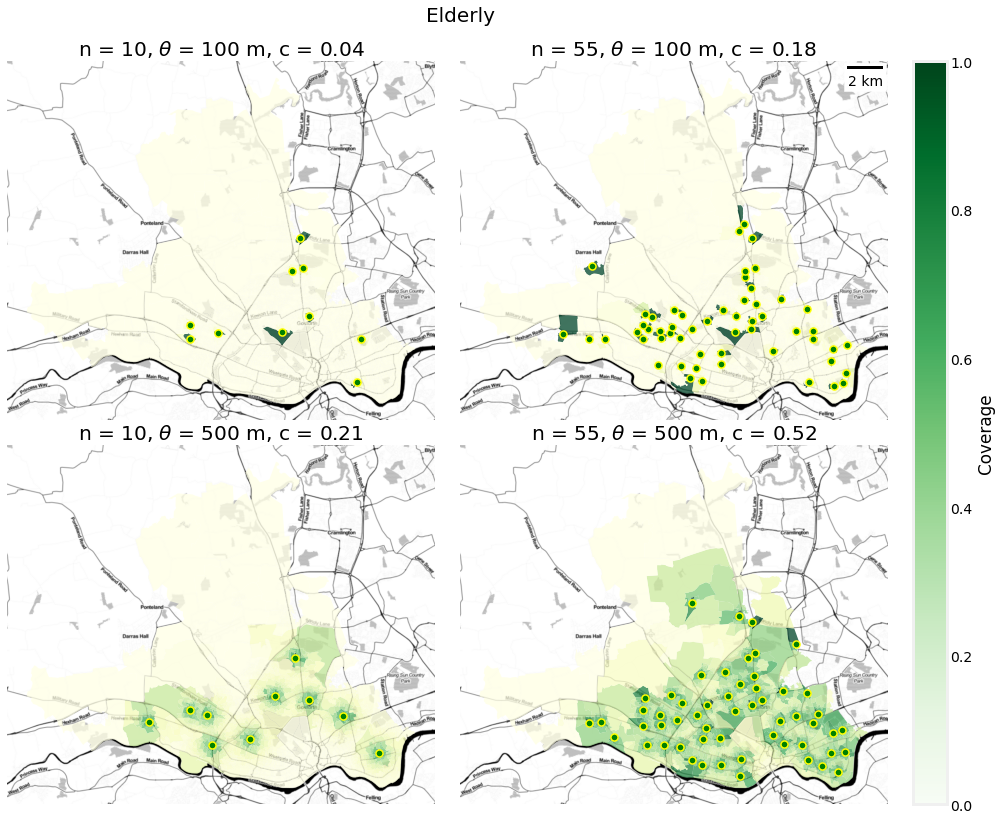

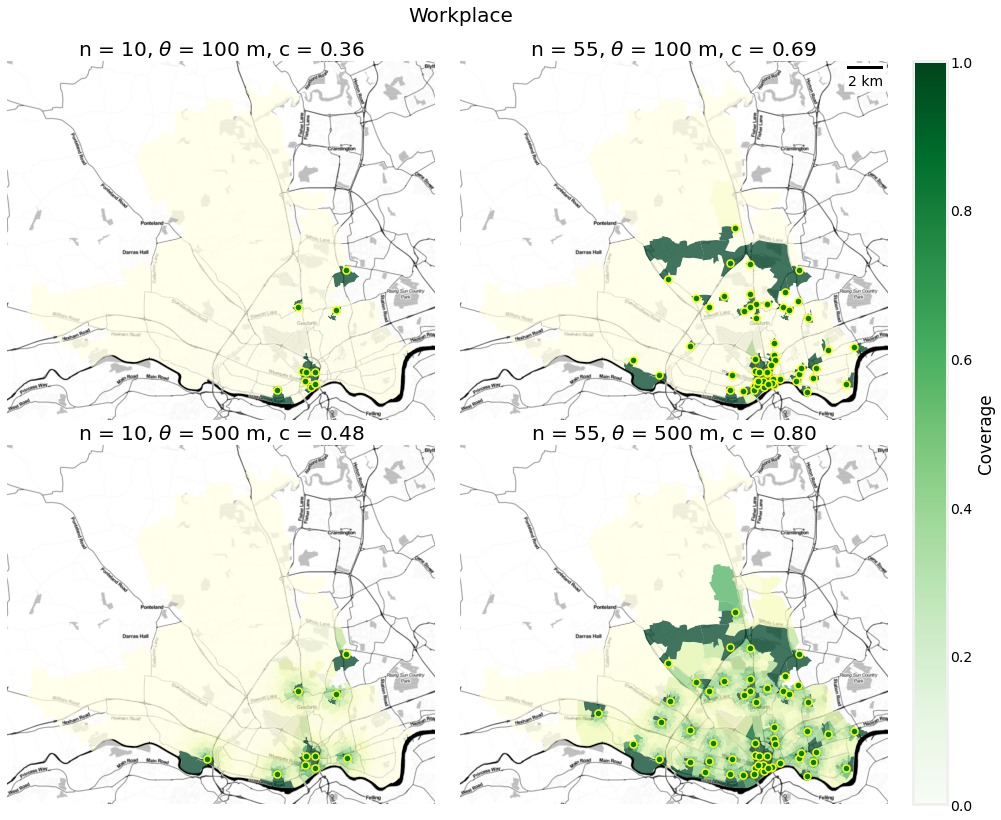

In [11]:
thetas_to_plot = [100, 500]
sensors_to_plot = [10, 55]

for plot_obj in all_groups.keys():
    fig, grid = get_fig_grid()
    i = 0
    for t in thetas_to_plot:
        for s in sensors_to_plot:
            r = results[plot_obj][f"theta{t}"][f"{s}sensors"]
            plot_optimisation_result(
                r,
                title=f"n = {s}, $\\theta$ = {t} m, c = {r['total_coverage']:.2f}",
                ax=grid[i],
                show=False,
                legend=False,
                sensor_size=50,
                sensor_color="green",
                sensor_edgecolor="yellow",
                sensor_linewidth=1.5,
            )
            if i == 1:
                add_scalebar(grid[i])

            i += 1

    add_colorbar(grid[-1], label="Coverage", cmap="Greens")

    fig.suptitle(all_groups[plot_obj]["title"], y=0.87, fontsize=20)
    t_str = "theta" + "_".join(str(t) for t in thetas_to_plot)
    n_str = "nsensors" + "_".join(str(n) for n in sensors_to_plot)
    save_fig(fig, f"{plot_obj}_{t_str}_{n_str}.png", save_dir)

## Comparison with existing network of air quality sensors


### Sensors at original locations (gridded coverage)

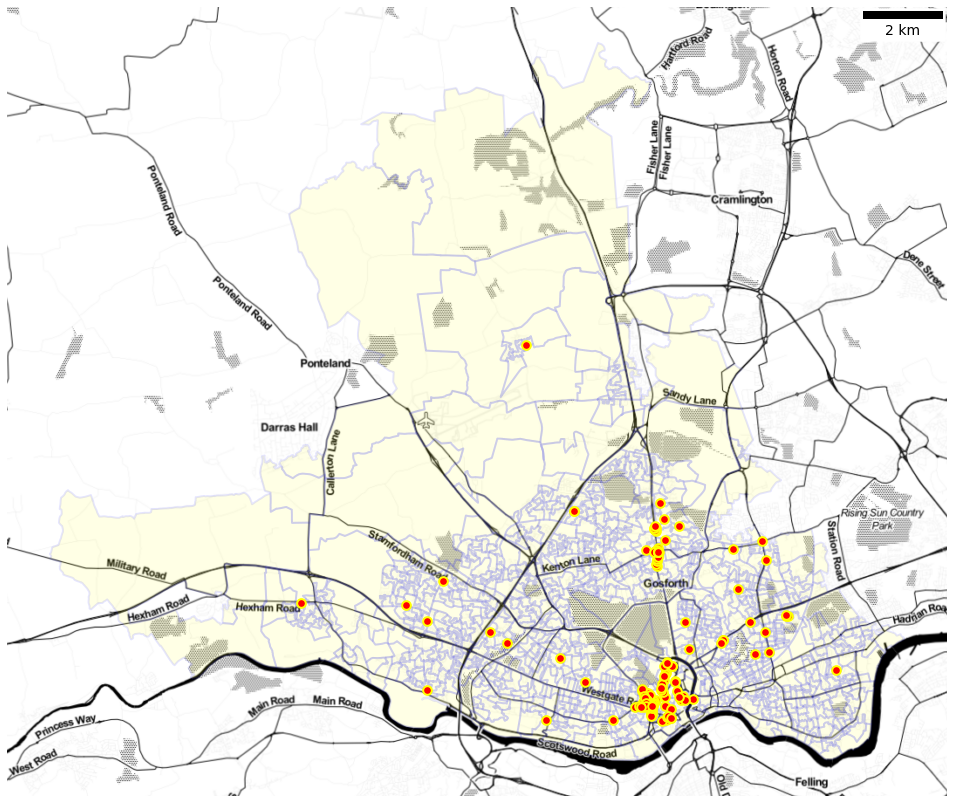

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
uo_sensors = get_uo_sensors()
plot_sensors(uo_sensors, centroids=False, ax=ax)
add_scalebar(ax)
t_str = f"theta_{theta}"
n_str = f"nsensors_{len(uo_sensors)}"
save_fig(fig, f"urb_obs_sensors_{t_str}_{n_str}.png", save_dir)

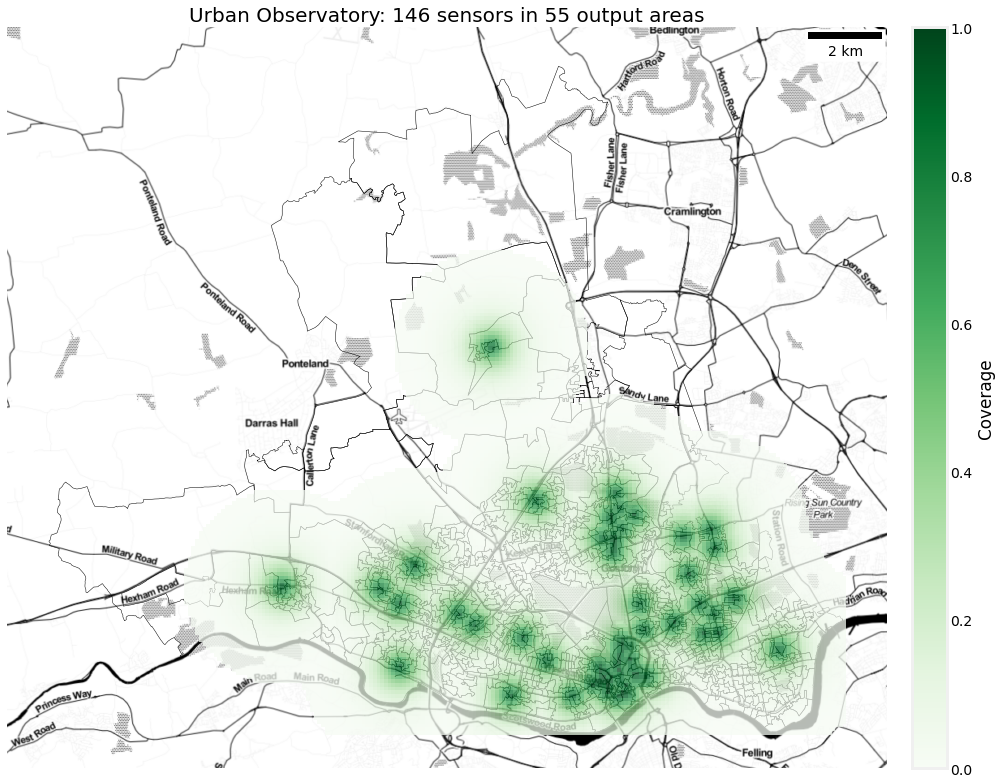

In [13]:
fig, ax = get_fig_grid(nrows_ncols=(1, 1))
ax = ax[0]
cmap = "Greens"
plot_uo_coverage_grid(ax=ax, legend=False, cmap=cmap)
add_colorbar(ax, cmap=cmap, label="Coverage")
add_scalebar(ax)
t_str = f"theta_{theta}"
n_str = f"nsensors_{len(uo_sensors)}"
save_fig(fig, f"urb_obs_coverage_grid_{t_str}_{n_str}.png", save_dir)

In [14]:
uo_sensors_xy = np.array(
    [uo_sensors["geometry"].x.values, uo_sensors["geometry"].y.values]
).T

oa = get_oa_shapes()
bounds = oa["geometry"].bounds
xlim = (bounds["minx"].min(), bounds["maxx"].max())
ylim = (bounds["miny"].min(), bounds["maxy"].max())

grid_size = 100
uo_cov = coverage_grid(uo_sensors_xy, xlim, ylim, theta=theta, grid_size=grid_size)

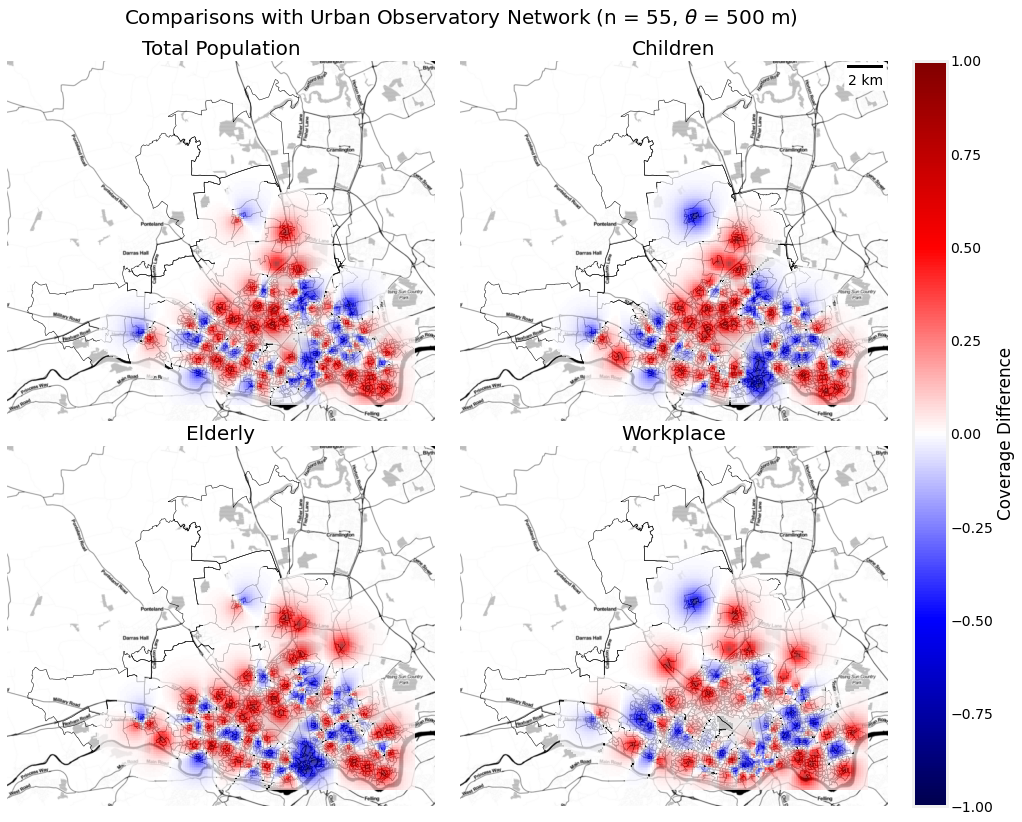

In [15]:
fig, grid = get_fig_grid()
cmap = "seismic"
vmin = -1
vmax = 1
n = 55
i = 0
for name, config in all_groups.items():
    greedy_sensors = pd.DataFrame(results[name]["theta500"][f"{n}sensors"]["sensors"])
    greedy_sensors = np.array(greedy_sensors[["x", "y"]])
    greedy_cov = coverage_grid(
        greedy_sensors, xlim, ylim, theta=theta, grid_size=grid_size
    )
    cov_diff = uo_cov.copy()
    cov_diff["coverage"] = greedy_cov["coverage"] - uo_cov["coverage"]

    plot_coverage_grid(
        cov_diff,
        ax=grid[i],
        vmin=vmin,
        vmax=vmax,
        legend=False,
        cmap=cmap,
        title=config["title"],
    )
    i += 1

add_scalebar(grid[1])
add_colorbar(grid[-1], cmap=cmap, vmin=vmin, vmax=vmax, label="Coverage Difference")

fig.suptitle(
    f"Comparisons with Urban Observatory Network (n = {n}, $\\theta$ = {theta} m)",
    y=0.87,
    fontsize=20,
)
t_str = f"theta_{theta}"
n_str = f"nsensors_{n}"
save_fig(fig, f"urb_obs_coverage_difference_grid_{t_str}_{n_str}.png", save_dir)

### Sensors snapped to OA centroids

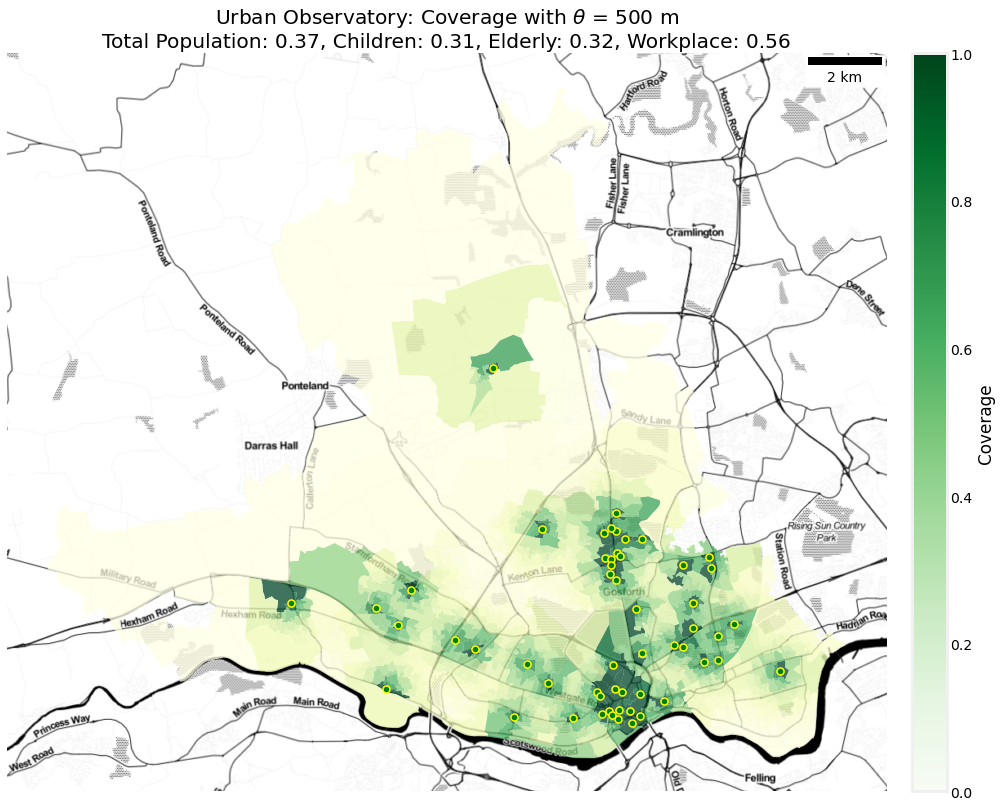

In [16]:
theta = 500
uo_sensor_dict = get_uo_sensor_dict()

uo_coverage = {}
title = f"Urban Observatory: Coverage with $\\theta$ = {theta} m\n"
for name, config in all_groups.items():
    uo_coverage[name] = calc_coverage(
        uo_sensor_dict, oa_weight=oa_weights[name], theta=theta
    )
    uo_coverage[name]["sensors"] = uo_sensor_dict
    title += f"{config['title']}: {uo_coverage[name]['total_coverage']:.2f}, "
title = title[:-2]

fig, ax = get_fig_grid(nrows_ncols=(1, 1))
plot_optimisation_result(
    uo_coverage[name],
    title=title,
    ax=ax[0],
    show=False,
    legend=False,
    sensor_size=50,
    sensor_color="green",
    sensor_edgecolor="yellow",
    sensor_linewidth=1.5,
)
add_scalebar(ax[0])
add_colorbar(ax[0], cmap="Greens", label="Coverage")

t_str = f"theta_{theta}"
n_str = f"nsensors_{len(uo_sensor_dict)}"
save_fig(fig, f"urb_obs_coverage_oa_{t_str}_{n_str}.png", save_dir)

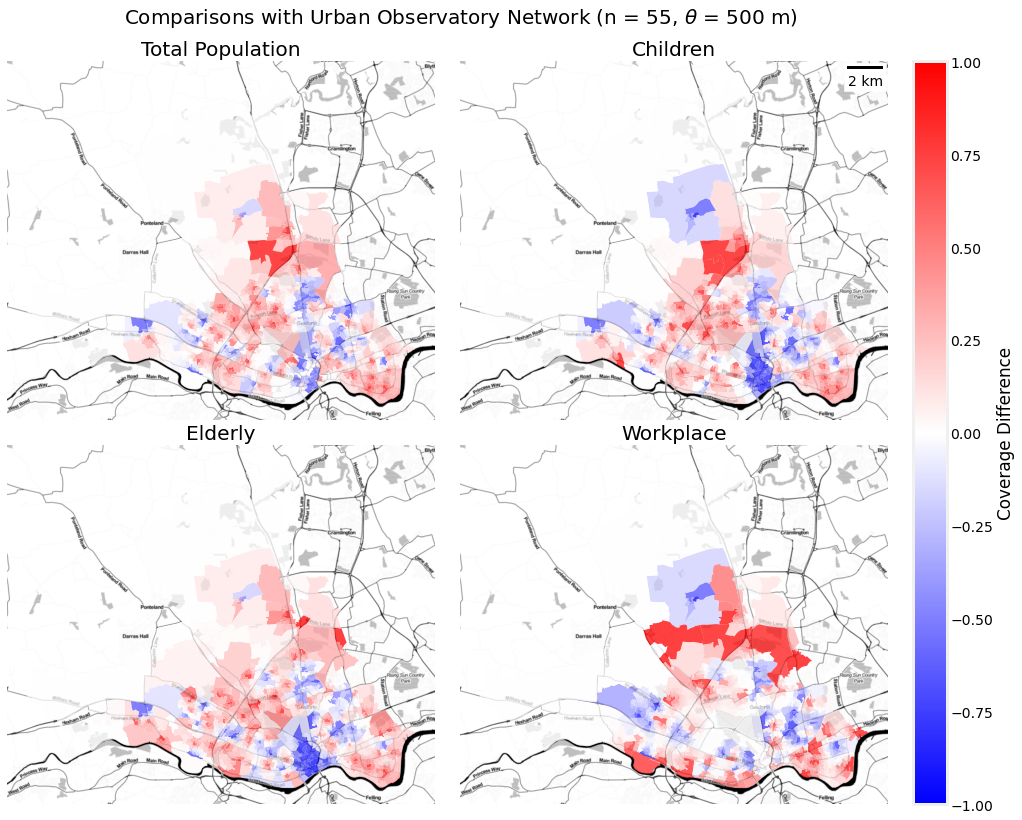

In [17]:
import contextily as ctx

fig, grid = get_fig_grid()
i = 0
for name, config in all_groups.items():
    uo_cov = uo_coverage[name]["oa_coverage"]
    uo_cov = pd.DataFrame(uo_cov).set_index("oa11cd")
    uo_cov.rename(columns={"coverage": "urb_obs"}, inplace=True)

    greedy_cov = results[name]["theta500"]["55sensors"]["oa_coverage"]
    greedy_cov = pd.DataFrame(greedy_cov).set_index("oa11cd")
    greedy_cov.rename(columns={"coverage": "greedy"}, inplace=True)

    compare_nets = uo_cov.join(greedy_cov)
    compare_nets["diff"] = compare_nets["greedy"] - compare_nets["urb_obs"]
    compare_nets["diff"].describe()

    oa_shapes = get_oa_shapes()
    oa_shapes = oa_shapes.join(compare_nets["diff"])

    cmap = "bwr"
    vmin = -1
    vmax = 1
    oa_shapes.plot(
        column="diff", alpha=0.75, cmap=cmap, ax=grid[i], vmin=vmin, vmax=vmax
    )

    ctx.add_basemap(
        grid[i],
        source="http://a.tile.stamen.com/toner/{z}/{x}/{y}.png",
        crs=oa_shapes.crs.to_epsg(),
    )

    grid[i].set_axis_off()
    grid[i].set_title(config["title"])
    i += 1

add_scalebar(grid[1])
add_colorbar(grid[-1], cmap=cmap, label="Coverage Difference", vmin=vmin, vmax=vmax)
fig.suptitle(
    f"Comparisons with Urban Observatory Network (n = {len(uo_sensor_dict)}, $\\theta$ = {theta} m)",
    y=0.87,
    fontsize=20,
)

t_str = f"theta_{theta}"
n_str = f"nsensors_{len(uo_sensor_dict)}"
save_fig(fig, f"urb_obs_coverage_difference_oa_{t_str}_{n_str}.png", save_dir)

In [18]:
cov = pd.DataFrame(results["pop_children"]["theta500"]["50sensors"]["oa_coverage"])
w = oa_weights["pop_children"]
w.name = "weight"
cov = cov.join(w, on="oa11cd")
np.average(cov["coverage"], weights=cov["weight"])

0.5188312513122988

## Multi-Objective Optimisation (Genetic Algorithm)

In [19]:
seed = 123
pg.set_global_rng_seed(seed=seed)

In [ ]:
n_sensors = [10, 55]
thetas = [500]
gen = 1000
population_size = 200
networks_path = Path(save_dir, "networks_multiobj.pkl")

inputs = get_optimisation_inputs(
    population_weight=1,
    workplace_weight=1,
    pop_age_groups=population_groups,
    combine=False,
)

if regen_results:
    results = {}
    for t in thetas:
        results[f"theta{t}"] = {}
        for ns in n_sensors:
            print("theta", t, ", n_sensors", ns)
            prob = build_problem(inputs, n_sensors=ns, theta=t)
            pop = run_problem(prob, uda=pg.nsga2(gen=gen), population_size=population_size, verbosity=1)
            results[f"theta{t}"][f"{ns}sensors"] = pop
            with open(networks_path, "wb") as f:
                pickle.dump(results, f)

else:
    with open(networks_path, "rb") as f:
        results = pickle.load(f)

theta 500 , n_sensors 10
theta 500 , n_sensors 55


---

Including deprivation somehow in the discussion of the analysis. Unfortunately there aren't any suitable datasets at the Output Area (OA) scale that was used for the other demographic variables. But as an alternative, we thought it might be useful to do a simple analysis / overlay, that takes the sensor networks derived from the spatial optimisation and assesses how well they would cover the city in terms of deprivation i.e. we would apply the network that was derived from the spatial distribution of OA-scale older persons variable to the LSOA-scale deprivation variable, and see what types of areas are "covered" in terms of deprivation. Do you think this would be useful? If so, that could be good  - or alternatively, I can generate this if you output the sensor networks from the optimisation as shapefiles?

---

Perhaps instead of deprivation we could use the genetic algorithm results with children x elderly x work population? That illustrated the trade-offs really well.
 
If we then showed a map of sensors and deprivation (IMD) in, eg, discussion, we could show how other factors are also likely to be important, even if we don't directly address them in the paper?
 
For the analysis, this could be something like:
 
- first cut of sensor location based on total population
 
- initial solo variable illustrations that show how coverage varies as number of sensors increases (similar to what we have now)
 
- analysis with combination of three variables that shows 1) how few solutions provide minimal coverage of all three variables and 2) how decisionmakers could operationalise trade-offs, which are very apparent in the results
 
Then discussion (or end of analysis section) could:
 
- compare part 1 of analysis to Urban Observatory locations, just as an illustration of differences
 
- compare part 1 (and part 3?) to a map of IMD in Newcastle
 